In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from lit_modules.densenet_lit import DenseNetLit
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger

L.seed_everything(42)
torch.set_float32_matmul_precision("medium")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.cuda.empty_cache()

Seed set to 42


Using device: cuda


In [2]:
IMAGE_SIZE = 32
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# source: https://pytorch.org/vision/stable/transforms.html
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
transforms_test = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
whole_dataset = datasets.EuroSAT(
    root="./data", download=True, transform=transforms_train
)
N = len(whole_dataset)
num_val = int(0.2 * N)
num_test = int(0.2 * N)
num_train = N - num_val - num_test
all_indices = list(range(N))
all_indices = torch.randperm(N).tolist()
indices_val = torch.randperm(N)[:num_val]
indices_test = torch.randperm(N)[:num_test]
train_indices = all_indices[:num_train]
val_indices = all_indices[num_train : num_train + num_val]
test_indices = all_indices[num_train + num_val : num_train + num_val + num_test]

train_dataset = torch.utils.data.Subset(whole_dataset, train_indices)
validation_dataset = torch.utils.data.Subset(whole_dataset, val_indices)
test_dataset = torch.utils.data.Subset(whole_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=512,
    num_workers=30,
    persistent_workers=True,
)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=512, num_workers=30, persistent_workers=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=512, num_workers=30, persistent_workers=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.4831376].


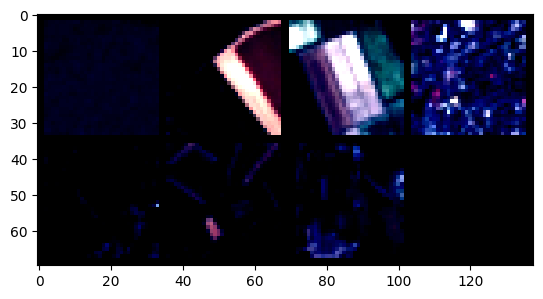

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def show_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


images, labels = next(iter(train_loader))
show_img(torchvision.utils.make_grid(images[:8], nrow=4, padding=2))

In [4]:
class DataModule(L.LightningDataModule):
    def __init__(self, train_loader, validation_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.test_loader = test_loader

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.validation_loader

    def test_dataloader(self):
        return self.test_loader


class DenseNetLit(DenseNetLit):
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=0.1,
            weight_decay=10e-4,
            momentum=0.9,
        )
        total_steps = self.trainer.estimated_stepping_batches
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            max_lr=1.0,
            total_steps=total_steps,
            div_factor=10,
            final_div_factor=23,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
                "strict": False,
            },
        }


data = DataModule(train_loader, validation_loader, test_loader)
hyperparameters = {
    "depth": 40,
    "first_output": 16,
    "growth_rate": 12,
    "dropout": 0.2,
}
model = DenseNetLit(hyperparameters=hyperparameters)
logger = MLFlowLogger(experiment_name="Densenet-EuroSat", save_dir="mlruns")
trainer = L.Trainer(
    max_epochs=50,
    logger=logger,
    callbacks=[
        ModelCheckpoint(
            monitor="val_accuracy",
            mode="max",
            dirpath="checkpoints/densenet-eurosat",
            filename="{epoch:02d}-{val_accuracy:.3f}",
        )
    ],
    precision="16-mixed",
    num_sanity_val_steps=0,
)
trainer.fit(model, datamodule=data)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dxzielinski/Desktop/github-repositories/optimization-data-analysis/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dxzielinski/Desktop/github-repositories/optimization-data-analysis/model_training_notebooks/checkpoints/densenet-eurosat exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/dxzielinski/Desktop/github-repositories/optimization-data-analysis/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name          | Type             | Params | Mode 
-

Epoch 49: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s, v_num=99d0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, v_num=99d0]


In [5]:
best_ckpt = trainer.checkpoint_callback.best_model_path
trainer.test(model, datamodule=data, ckpt_path=best_ckpt)
None

Restoring states from the checkpoint path at /home/dxzielinski/Desktop/github-repositories/optimization-data-analysis/model_training_notebooks/checkpoints/densenet-eurosat/epoch=48-val_acc=0.000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/dxzielinski/Desktop/github-repositories/optimization-data-analysis/model_training_notebooks/checkpoints/densenet-eurosat/epoch=48-val_acc=0.000.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:01<00:00,  9.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8849999904632568
       test_auroc            0.993626594543457
      test_f1_macro         0.8816047310829163
     test_precision         0.8914507627487183
       test_recall          0.8775404691696167
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [7]:
# save test_indices to .txt file
with open("../test_indices.txt", "w") as f:
    for idx in test_indices:
        f.write(f"{idx}\n")